In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, math

Opis eksperymentu.

Eksperyment został przeprowadzony na klasterze "jabba", na 8 węzłach (vnode 05-vnode12) o takiej samej mocy.
Eksperyment został przeprowadzony w dwóch częsciach - wersja skalowalna i nieskalowalna. 
Kod został napisany w języku Python, część obliczającą metryki, generująca wykresy zaimplementowano w Jupyter Notebook. Do sprawozdania dołączono skrypty bashowe pr Ten sam kod był uruchamiany dla wersji skalowalnej i nieskalowalnej, uruchomiony jednak z innymi parametrami. Wspólną częścia był fakt, że wykorzystano model "master-slave", w którym jeden węzeł był masterem i pozostałe procesy przesyłały do niego swoje rezultaty. Te częściowe rezultaty to liczba wylosowanych punktów, które znalazły się w kole. Następnie master sumował cześciowe rezultaty i zwracał obliczoną liczbę pi. Do synchronizacji użyto funkcji gather. Oprócz tego użyto jednej bariery. Czas mierzono na masterze, przy czym do momentu otrzymania rezultatów, czas sumowania i obliczania PI nie został uwzględniony w pomiarach czasu.

Jeżeli chodzi o obliczenia to wykonano dwie części. W pierwszej części wyznaczono część "T1",(część sekwencyjna) poprzez dla każdej liczby punktów w eksperymencie (10000, 100000000, 500000000), uruchomienie programu dla jednego rdzenia.
Następnie jako T1 wzięto minimum z 10 wyników dla każdej liczby punktów. To T1 było potem podstawą do obliczenia metryk.

Druga część obliczeń to właściwa część eksperymentu. Dla części skalowalnej, uruchomiono dla trzech grup punktów,
dla liczby rdzeni od 1 do 8, tą samą liczbę punktów (liczba punktów to N*P, gdzie N to liczba punktów ze zbioru {10000,100000000,500000000}, P to liczba rdzeni {1...8})
Dla części nieskalowalnej, liczba punktów była niezależna od liczby procesów i wynosiła liczbę ze zbioru {10000,100000000,500000000}.
Wyznaczono metryki zgodnie ze wzorami ze slajdów z wykładu i przedstawiono wykresy.




In [67]:
NUMBER_OF_CORES = 8
PI = "3.1415926535"

In [68]:
def how_many_digits_match(dec):
    dec_as_str = str(dec)
    common_digits = len(os.path.commonprefix([dec_as_str, str(PI)]))
    return max(common_digits-2, 0)

In [70]:
def call_function_for_groups(func, groups, **params):
    for group in groups:
        func(group, params)

In [71]:
def calculate_T1_time(file_path):
    def plot(values, number_of_points1):
        plt.scatter(np.arange(1, 11), y=values.values)
        plt.xticks(np.arange(1, 11))
        plt.xlabel("Numer proby")
        plt.ylabel("Czas uruchomienia (s)")
        plt.title("Czas wykonania T1 dla n=" + str(number_of_points1) + " punktow")
        plt.legend(["Mean: " + str(values.mean()) + ",\n Min: " + str(values.min()) + 
                    "\n Max: " + str(values.max())])
        plt.show()
        return values.min()
    
    file = pd.read_csv(file_path)
    first = file.query('points==10000')
    second = file.query('points==100000000')
    last = file.query('points==500000000')
    
    first_mean = plot(first['time'], 10000)
    second_mean = plot(second['time'], 100000000)
    last_mean = plot(last['time'], 500000000 )
    return first_mean, second_mean, last_mean
    print (first_mean, second_mean)
#     return first_mean, second_mean, None

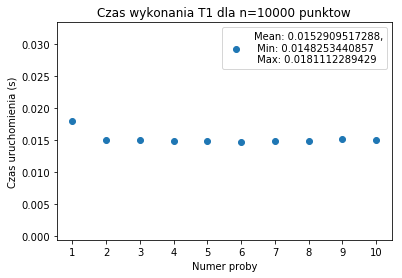

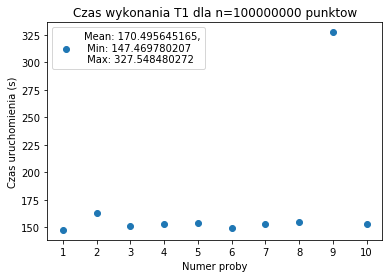

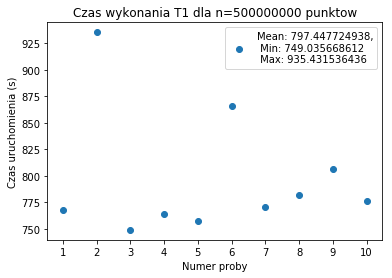

In [72]:
first_mean, second_mean, last_mean = calculate_T1_time("pi/results_scalable_t1.txt")

Rezultaty wykonania eksperymentu w wersji skalowalnej, tzn każdy węzeł wykonuje obliczenia na liczbie punktów w kolumnie points. Kolumna proc przedstawia liczbę rdzeni użytych w eksperymencie

In [73]:
file_path = "pi/results_scalable_v2.txt"
csv = pd.read_csv(file_path)
print (csv)


          time        pi  proc     points
0     0.017682  3.141200     1      10000
1     0.015318  3.126400     2      10000
2     0.015181  3.134400     3      10000
3     0.015299  3.141900     4      10000
4     0.015390  3.140560     5      10000
5     0.015458  3.143867     6      10000
6     0.020481  3.140629     7      10000
7     0.028362  3.143300     8      10000
8   147.303900  3.141751     1  100000000
9   152.993256  3.141528     2  100000000
10  150.803446  3.141445     3  100000000
11  151.949884  3.141556     4  100000000
12  156.963917  3.141529     5  100000000
13  158.124833  3.141521     6  100000000
14  152.844666  3.141607     7  100000000
15  151.938042  3.141652     8  100000000
16  786.294801  3.141610     1  500000000
17  777.576188  3.141654     2  500000000
18  785.787763  3.141628     3  500000000
19  821.974979  3.141604     4  500000000
20  768.184667  3.141622     5  500000000
21  774.389249  3.141606     6  500000000
22  790.103426  3.141599     7  50

In [74]:
grouped_by = csv.groupby('proc', axis=0)

In [75]:
first_group = grouped_by.nth(n=0)
second_group = grouped_by.nth(n=1)
last_group = grouped_by.nth(n=2)

In [112]:
def plot_accuracy(group, scalable):
    pi_results = group['pi']
    points = group['points'].mean()
    match = pi_results.map(lambda x: how_many_digits_match(x))
    if scalable:
        plt.title('Liczba cyfr po przecinku PI w zaleznosci od liczby rdzeni \n'
                    + ' kazdy rdzen oblicza ' + str(points) + ' punktow')
    else:
        plt.title("Liczba cyfr po przecinku PI w zaleznosci od liczby rdzeni \n " 
                    + 'calkowita liczba punktow '+ str(int(points)))
    plt.xlabel('Liczba rdzeni')
    plt.ylabel('Poprawnie wyznaczona liczba cyfr \n po przecinku liczby PI')
    plt.scatter(np.arange(1, NUMBER_OF_CORES+1), match)
    plt.yticks(np.arange(0, max(match) + 2))
    plt.show()

In [ ]:
plot_accuracy(first_group, True)
plot_accuracy(second_group, True)
plot_accuracy(last_group, True)

In [116]:
# TODO: czas dzialania w zaleznosci od liczby corow
def plot_time_of_execution(group, scalable=True):
    time = group['time']
    points = group['points'].mean()
    if scalable:
        plt.title("Czas wykonania. Kazdy rdzeni losuje " + str(int(points)) + " punktow")
    else:
        plt.title("Czas wykonania. Calkowta liczba punkto wynosi " + str(int(points)))
    plt.xlabel('Liczba rdzeni')
    plt.ylabel('Czas wykonania (s)')
    plt.scatter(np.arange(1,NUMBER_OF_CORES+1), y=time)
    plt.xticks(np.arange(1,NUMBER_OF_CORES+1))
    plt.show()

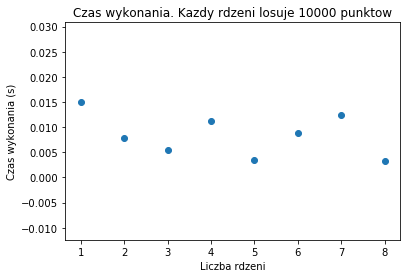

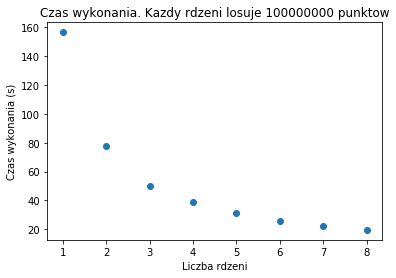

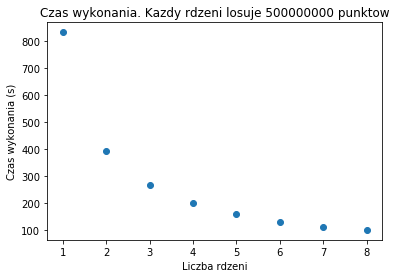

In [117]:
call_function_for_groups(
    plot_time_of_execution, [first_group, second_group, last_group], scalable=True)

In [80]:
def plot_speedup(group, time_for_one, scalable):
    speedup = []
    for index, row in group.iterrows():
        if scalable:
            value = (time_for_one / row['time']) * index
        else:
            value = (time_for_one / row['time'])
        speedup.append(value)
    points = group['points'].mean()
    if scalable:
        plt.title("Speedup scalable, kazdy rdzen losuje " + str(int(points)) + " punktow")
    else:
        plt.title("Speedup, liczba punktow wynosi " + str(int(points)))
    plt.xlabel('Liczba rdzeni')
    plt.ylabel("Speedup")
    plt.plot(np.arange(1,NUMBER_OF_CORES+1), np.arange(1,NUMBER_OF_CORES+1), 'r--')
    plt.text(1, 5, 'Krzywa teoretyczna')
    plt.scatter(np.arange(1, NUMBER_OF_CORES+1), y=speedup)
    plt.xticks(np.arange(1,NUMBER_OF_CORES+1))
    plt.show()

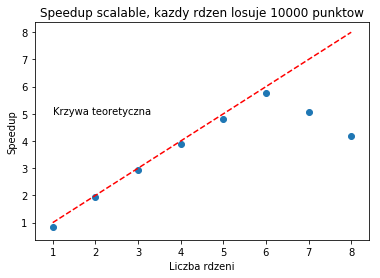

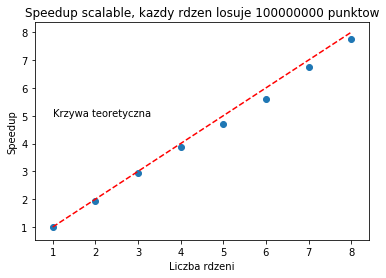

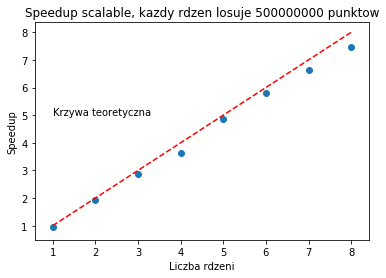

In [81]:
plot_speedup(first_group, time_for_one = first_mean, scalable=True)
plot_speedup(second_group, time_for_one = second_mean, scalable=True)
plot_speedup(last_group, time_for_one = last_mean, scalable=True)




In [82]:
def plot_efficiency(group, time_for_one, scalable):
    points = group['points'].mean()
    eff = []
    for index, row in group.iterrows():
        if scalable:
            value = (time_for_one / row['time'])
        else:
            value = (time_for_one / row['time']) / index
        eff.append(value)
    if scalable:
        plt.title("Efficiency scalable, kazdy rdzen losuje " + str(int(points)) + " punktow")
    else:
        plt.title("Efficiency, sumaryczna liczba punkto wynosi " + str(int(points)))
    plt.xlabel('Liczba rdzeni')
    plt.ylabel("Efficiency")
    plt.scatter(np.arange(1,NUMBER_OF_CORES+1), eff)
    plt.xticks(np.arange(1,NUMBER_OF_CORES+1))
    plt.show()

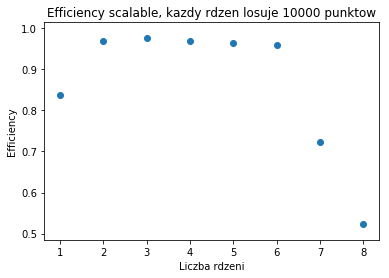

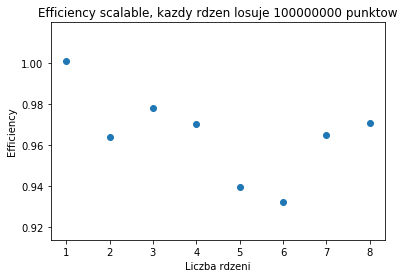

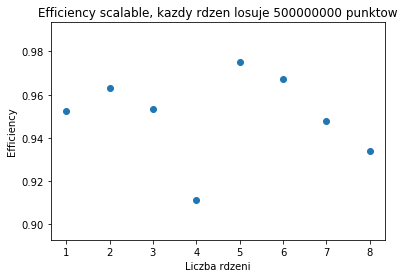

In [83]:
plot_efficiency(first_group, first_mean, scalable=True)
plot_efficiency(second_group, second_mean, scalable=True)
plot_efficiency(last_group, last_mean, scalable=True)


In [84]:
def plot_serialfraction(group, time_for_one, scalable):
    serial_fraction = []
    for index, row in group.iterrows():
        if scalable:
            speedup = (time_for_one / row['time']) * index
        else:
            speedup = (time_for_one / row['time'])
        speedup_value = speedup
        sf_value = (1/speedup_value - 1/index) / (1 - 1/index)
        serial_fraction.append(sf_value)
    points = group['points'].mean()
    if scalable:
        plt.title("Serial fraction scalable, kazdy rdzen losuje " + str(int(points)) + " punktow")
    else:
        plt.title("Serial fraction, liczba punktow " + str(int(points)))
    plt.xlabel('Liczba rdzeni')
    plt.ylabel("Serial fraction")
    plt.scatter(np.arange(1, NUMBER_OF_CORES+1), y=serial_fraction)
    plt.xticks(np.arange(1,NUMBER_OF_CORES+1))
    plt.show()

/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


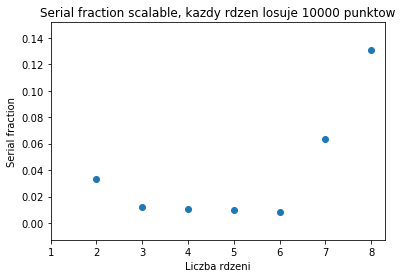

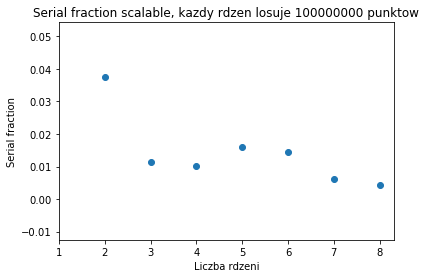

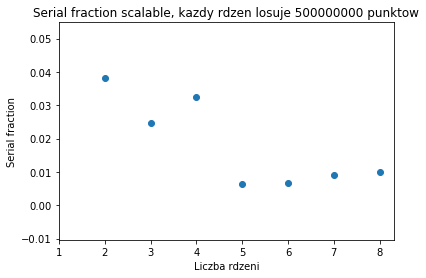

In [85]:
plot_serialfraction(first_group, first_mean, scalable=True)
plot_serialfraction(second_group, second_mean, scalable=True)
plot_serialfraction(last_group, last_mean, scalable=True)

In [86]:
#
# ,--.  ,--.,-----.,--.  ,--.     ,---.  ,-----. ,---. ,--.    ,---. ,-----. ,--.  ,------. 
# |  ,'.|  '  .-.  |  ,'.|  |    '   .-''  .--.//  O  \|  |   /  O  \|  |) /_|  |  |  .---' 
# |  |' '  |  | |  |  |' '  |    `.  `-.|  |   |  .-.  |  |  |  .-.  |  .-.  |  |  |  `--,  
# |  | `   '  '-'  |  | `   ,----.-'    '  '--'|  | |  |  '--|  | |  |  '--' |  '--|  `---. 
# `--'  `--'`-----'`--'  `--'----`-----' `-----`--' `--`-----`--' `--`------'`-----`------' 
#

Wyniki eksperymentu dla wersji nieskalowalnej. Wartości w kolumnie points przedstawiają ile punktów w sumie zostało policzonych na liczbie rdzeni przedstawionej w kolumnie proc

In [87]:
file_path = "pi/results_nonscalable_v2.txt"
csv = pd.read_csv(file_path)
print (csv)
grouped_by = csv.groupby('proc', axis=0)
first_group = grouped_by.nth(n=0)
second_group = grouped_by.nth(n=1)
last_group = grouped_by.nth(n=2)

          time        pi  proc     points
0     0.015075  3.133200     1      10000
1     0.007838  3.152000     2      10000
2     0.005402  3.123600     3      10000
3     0.011276  3.152400     4      10000
4     0.003554  3.127200     5      10000
5     0.008916  3.180800     6      10000
6     0.012359  3.119200     7      10000
7     0.003362  3.132800     8      10000
8   156.555125  3.141646     1  100000000
9    77.366416  3.141532     2  100000000
10   49.795954  3.141912     3  100000000
11   38.877074  3.141566     4  100000000
12   31.057047  3.141506     5  100000000
13   25.931837  3.141550     6  100000000
14   22.251457  3.141430     7  100000000
15   19.509623  3.141653     8  100000000
16  833.022220  3.141618     1  500000000
17  393.749649  3.141644     2  500000000
18  264.755649  3.141684     3  500000000
19  199.825974  3.141605     4  500000000
20  159.985952  3.141689     5  500000000
21  130.238497  3.141741     6  500000000
22  112.443217  3.141541     7  50

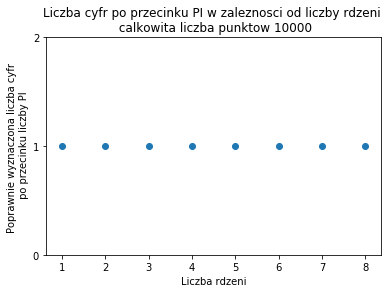

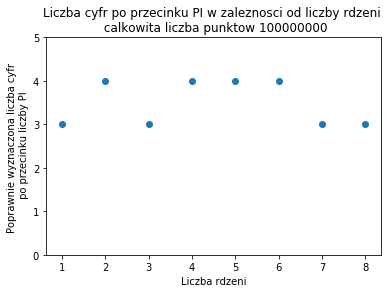

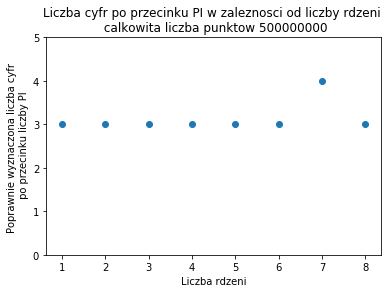

In [115]:
plot_accuracy(first_group, scalable=False)
plot_accuracy(second_group, scalable=False)
plot_accuracy(last_group, scalable=False)

          pi  points      time
proc                          
1     3.1332   10000  0.015075
2     3.1520   10000  0.007838
3     3.1236   10000  0.005402
4     3.1524   10000  0.011276
5     3.1272   10000  0.003554
6     3.1808   10000  0.008916
7     3.1192   10000  0.012359
8     3.1328   10000  0.003362


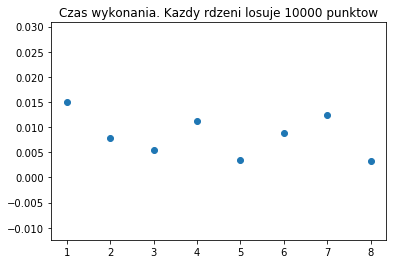

            pi     points        time
proc                                 
1     3.141646  100000000  156.555125
2     3.141532  100000000   77.366416
3     3.141912  100000000   49.795954
4     3.141566  100000000   38.877074
5     3.141506  100000000   31.057047
6     3.141550  100000000   25.931837
7     3.141430  100000000   22.251457
8     3.141653  100000000   19.509623


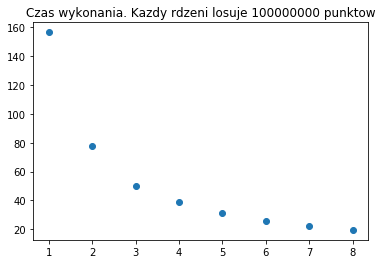

            pi     points        time
proc                                 
1     3.141618  500000000  833.022220
2     3.141644  500000000  393.749649
3     3.141684  500000000  264.755649
4     3.141605  500000000  199.825974
5     3.141689  500000000  159.985952
6     3.141741  500000000  130.238497
7     3.141541  500000000  112.443217
8     3.141662  500000000  100.045475


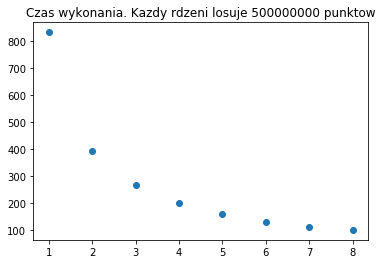

In [89]:
call_function_for_groups(
    plot_time_of_execution, [first_group, second_group, last_group], scalable=False)

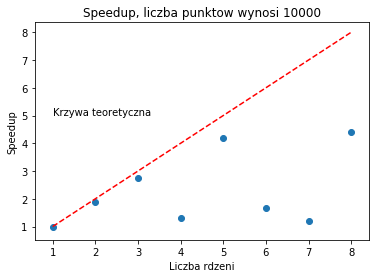

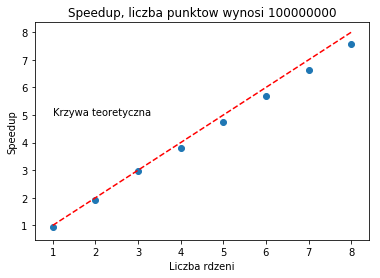

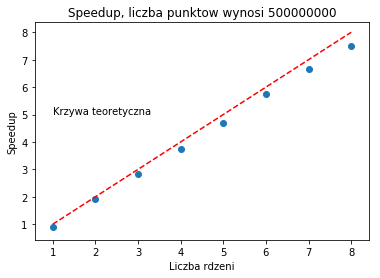

In [90]:
plot_speedup(first_group, time_for_one = first_mean, scalable=False)
plot_speedup(second_group, time_for_one = second_mean, scalable=False)
plot_speedup(last_group, time_for_one = last_mean, scalable=False)


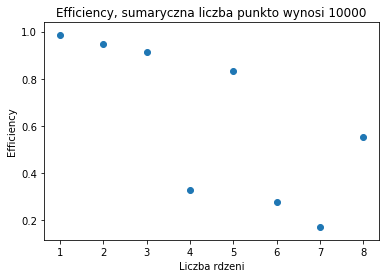

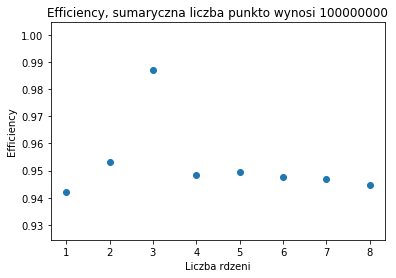

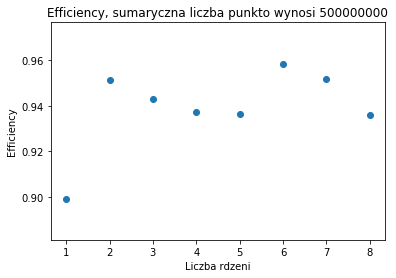

In [91]:
plot_efficiency(first_group, first_mean, scalable=False)
plot_efficiency(second_group, second_mean, scalable=False)
plot_efficiency(last_group, last_mean, scalable=False)


/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


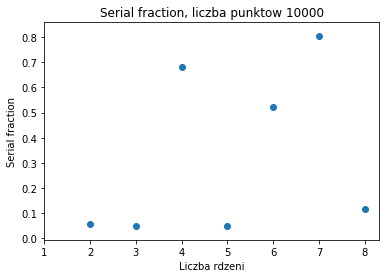

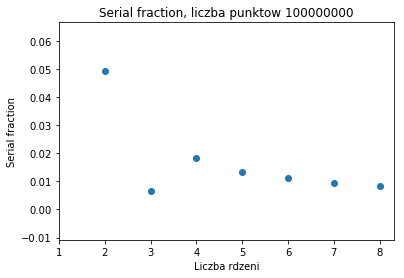

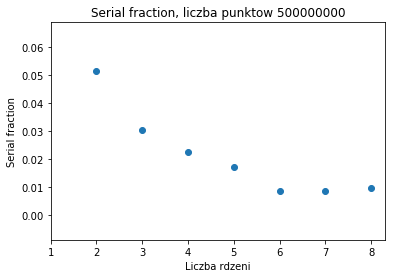

In [92]:
plot_serialfraction(first_group, first_mean, scalable=False)
plot_serialfraction(second_group, second_mean, scalable=False)
plot_serialfraction(last_group, last_mean, scalable=False)

Wnioski:
Problem obliczenia liczby PI metodą Monte Carlo okazał się w praktyce "naturalnie równoległy". (krzywa speedup dla liczby punktów = 10^8, 5*10^8 to praktycznie "krzywa teoretyczna", podobnie jak miara efficiency ~0.95 zarówno dla wersji skalowalnej i nieskalowalnej).
Niska wartość metryki serial fraction świadczy o dobrym zrówolegleniu problemu.

Poprawione wyznaczono 3-4 cyfry po przecinku liczby PI dla 10^8 i 5*10^8 punktów, dla 10^4 wyznaczono poprawnie jedną cyfrę po przecinku.